In [193]:
# DSC630
# Week 10
# Term Project
# Author: Nathanael Ochoa
# 08/10/24

# Milestone 5 - Term Project

In [194]:
# Import packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [195]:
# Import data
data = pd.read_csv("jewelry - Copy.csv")

In [196]:
# Dataframe check
type(data)

pandas.core.frame.DataFrame

In [197]:
# Dataframe shape
print(f'Data dimensions: {data.shape}')

Data dimensions: (95911, 13)


In [198]:
# Preview first row of dataset
data.head(1).stack()

0  order_datetime    2018-12-01 11:40:29 UTC
   order_id              1924719191579951782
   product_id            1842195256808833386
   qty                                     1
   category_id         1806829201890738432.0
   category_alias            jewelry.earring
   brand_id                              0.0
   price                              561.51
   user_id             1515915625207851264.0
   main_color                            red
   main_metal                           gold
   main_gem                          diamond
dtype: object

I noticed some rows had empty values in the 'user_id' and 'price' columns because the values were shifted two spaces to the left. I observed this issue while inspecting the data in Excel, so it’s best to correct it now.

In [199]:
# New dataframe that contains the rows that contain 
# NaN values in the 'user_id' column
empty_users = data[data["user_id"].isnull()]

In [200]:
# Count of rows that contain NA values in the 'user_id' column
len(empty_users)

5352

In [201]:
# 'Moves' the misplaced data to the correct columns
for idx, row in empty_users.iterrows():
    # Sets price value equal to category_alias value
    row["price"] = row["category_alias"]  
    row["category_alias"] = np.nan  # Sets category_alias value to NaN
    
    row["user_id"] = row["brand_id"]  # Sets user_id value equal to brand_id value
    row["brand_id"] = np.nan  # Sets brand_id value to NaN
    
    data.loc[idx] = row  # Updates the original dataset with these changes

In [202]:
# Count of rows that contain NaN values in the 'user_id' column 
# after making the above changes
data['user_id'].isnull().sum()

0

I will replace empty values in the 'product_gender' column with 'u', which represents unisex. To fill in this column, I can use the 'category_alias' column as a reference. For instance, every record with 'jewelry.necklace' has 'f' in the 'product_gender' column. However, since there can be male or unisex necklaces, I have decided to use 'u' for the null values.

Null values in the 'main_gem' column will be filled with 'unknown-gem'. There is already a value 'unknown-color' in the 'main_color' column, so this approach maintains consistency with the existing dataset.

Null values in the 'brand_id' column will be replaced with -1 to indicate that the product does not have a brand.

These are the null values that will be addressed. The remaining null values will be dropped from the dataset altogether.

In [203]:
# Fill in NaN values in the data
data['product_gender'].fillna('u', inplace = True)
data['main_gem'].fillna('unknown-gem', inplace = True)
data['brand_id'].fillna(-1, inplace = True)

In [204]:
# Create new dataframe using copy() and dropna() functions
dropped_na_data = data.copy().dropna()

In [205]:
# Filling in some of the NaN values has helped keep a large amount of records
print(f'Original record count: {len(data)}')
print(f'New record count:      {len(dropped_na_data)}')
print(f'Records lost:          {len(data) - len(dropped_na_data)}')

Original record count: 95911
New record count:      78391
Records lost:          17520


Next, I'll update the column data types as needed.

In [206]:
# View column data types
dropped_na_data.dtypes

order_datetime     object
order_id            int64
product_id          int64
qty                 int64
category_id       float64
category_alias     object
brand_id          float64
price              object
user_id           float64
product_gender     object
main_color         object
main_metal         object
main_gem           object
dtype: object

In [207]:
# Use this to convert 'order_datetime' to datetime format
dropped_na_data['order_datetime'] = pd.to_datetime(dropped_na_data['order_datetime'])

# Set as index and drop original 'order_datetime' column
dropped_na_data.set_index('order_datetime', inplace = True)

In [208]:
# Convert columns to appropriate data types
dropped_na_data["category_id"] = dropped_na_data["category_id"].astype('Int64')
dropped_na_data["category_alias"] = dropped_na_data["category_alias"].astype(str)
dropped_na_data["brand_id"] = dropped_na_data["brand_id"].astype(int)
dropped_na_data["price"] = dropped_na_data["price"].astype(float)
dropped_na_data["user_id"] = dropped_na_data["user_id"].astype('Int64')
dropped_na_data["product_gender"] = dropped_na_data["product_gender"].astype(str)
dropped_na_data["main_color"] = dropped_na_data["main_color"].astype(str)
dropped_na_data["main_metal"] = dropped_na_data["main_metal"].astype(str)
dropped_na_data["main_gem"] = dropped_na_data["main_gem"].astype(str)

In [209]:
# Ensure the changes were made correctly
dropped_na_data.dtypes

order_id            int64
product_id          int64
qty                 int64
category_id         Int64
category_alias     object
brand_id            int32
price             float64
user_id             Int64
product_gender     object
main_color         object
main_metal         object
main_gem           object
dtype: object

In [210]:
# Preview first row of data after updating column data types
dropped_na_data.head(1).stack()

order_datetime                           
2018-12-01 11:40:29+00:00  order_id          1924719191579951782
                           product_id        1842195256808833386
                           qty                                 1
                           category_id       1806829201890738432
                           category_alias        jewelry.earring
                           brand_id                            0
                           price                          561.51
                           user_id           1515915625207851264
                           product_gender                      u
                           main_color                        red
                           main_metal                       gold
                           main_gem                      diamond
dtype: object

# Product Recommender System - Content-Based Filtering

In [211]:
# Create a copy of the dataset and name it something different
rec_sys = dropped_na_data.copy()

In [212]:
# Drop duplicates based on product_id
features = rec_sys[['product_id', 'category_alias', 'product_gender', 
                    'main_color', 'main_metal']].drop_duplicates()

In [213]:
# One-hot encode the categorical features
encoded = pd.get_dummies(features, columns = ['category_alias', 'product_gender', 
                                              'main_color', 'main_metal'])

In [214]:
# Create item-feature matrix with product_id as index
item_feature_matrix = encoded.set_index('product_id')

In [215]:
# Compute cosine similarity between items
item_similarity = cosine_similarity(item_feature_matrix)
item_similarity_df = pd.DataFrame(item_similarity, 
                                  index = item_feature_matrix.index, 
                                  columns = item_feature_matrix.index)

In [216]:
# Function that returns 10 recommended items from the store. 
# These items have not been purchased by the user.
def recommend_items(user_id, df, item_similarity_df, top_n = 10):
    # Get items purchased by the user
    user_purchases = df[df['user_id'] == user_id]['product_id']
    
    # Calculate scores for items not purchased by the user
    scores = pd.Series(0, index = item_similarity_df.columns)
    
    for item in user_purchases:
        if item in item_similarity_df.index:
            similar_items = item_similarity_df[item]
            scores += similar_items
            
    # Remove items already purchased by the user
    scores = scores.drop(user_purchases, errors = 'ignore')
    
    # Return top N recommended items
    return scores.sort_values(ascending = False).head(top_n)

In [217]:
# User with the most purchases will be used
chosen_user = rec_sys['user_id'].mode().iloc[0]
recommendations = recommend_items(chosen_user, rec_sys, item_similarity_df)

In [218]:
# Display output and loop through returned series
print(f"The following store items are recommended for user {chosen_user}.")
print()
string1 = "product_id: category_alias - product_gender - "
string2 = "main_color - main_metal - main_gem - price"
print(string1 + string2)
for product_id in recommendations.index:
    category = rec_sys[rec_sys['product_id'] == product_id]['category_alias'].iloc[0]
    gender = rec_sys[rec_sys['product_id'] == product_id]['product_gender'].iloc[0]
    color = rec_sys[rec_sys['product_id'] == product_id]['main_color'].iloc[0]
    metal = rec_sys[rec_sys['product_id'] == product_id]['main_metal'].iloc[0]
    gem = rec_sys[rec_sys['product_id'] == product_id]['main_gem'].iloc[0]
    price = rec_sys[rec_sys['product_id'] == product_id]['price'].iloc[0]
    string3 = f"{product_id}: {category} - {gender} - "
    string4 = f"{color} - {metal} - {gem} - ${price}"
    print(string3 + string4)

The following store items are recommended for user 1515915625245643008.

product_id: category_alias - product_gender - main_color - main_metal - main_gem - price
1515966222980043408: jewelry.ring - f - red - gold - diamond - $335.48
1515966223158066417: jewelry.ring - f - red - gold - diamond - $280.68
1855231075249291734: jewelry.ring - f - red - gold - diamond - $123.15
1515966223275024801: jewelry.ring - f - red - gold - fianit - $123.15
1515966223478625523: jewelry.ring - f - red - gold - diamond - $343.15
1515966223183803116: jewelry.ring - f - red - gold - unknown-gem - $168.36
1956663848211579723: jewelry.ring - f - red - gold - emerald - $280.68
1852230387330188242: jewelry.ring - f - red - gold - unknown-gem - $308.08
1839998982592397760: jewelry.ring - f - red - gold - diamond - $177.95
1956663847666319768: jewelry.ring - f - red - gold - topaz - $102.6


The recommender will be extremely useful as it suggests items that are very similar. I excluded the 'main_gem' column during the development phase to ensure some variability in the recommendations.

# Inventory Management - Exponential Smoothing

I encountered some issues with my dataset while trying to create an ARIMA model for inventory management. As a result, I decided to use an Exponential Smoothing model instead. For the model analysis, I selected the product with the most occurrences in the dataset. I have also included a preview of the variables that describe the item I will be using.

In [219]:
# A preview of the variables that describe the product we are going to use 
# for analysis
q = 'product_id == 1956663840242401751'
dropped_na_data.query(q)[['category_alias', 'brand_id', 'price', 
                          'product_gender', 'main_color', 'main_metal', 
                          'main_gem']].iloc[0]

category_alias    jewelry.ring
brand_id                     0
price                   259.97
product_gender               f
main_color                 red
main_metal                gold
main_gem           unknown-gem
Name: 2019-01-20 17:03:41+00:00, dtype: object

In [220]:
# Aggregate sales data by month
monthly_sales = dropped_na_data.groupby([pd.Grouper(freq = 'M'), 
                                         'product_id'])['qty'].sum().reset_index()

# Select a specific product_id for analysis
product_id = 1956663840242401751
product_sales = monthly_sales[monthly_sales['product_id'] == product_id]

# Set 'order_datetime' as index
product_sales.set_index('order_datetime', inplace = True)

In [221]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # Apply Exponential Smoothing (Holt-Winters' multiplicative seasonal method)
    model = ExponentialSmoothing(product_sales['qty'], trend = 'add', 
                                 seasonal = 'mul', seasonal_periods = 12)
    fit = model.fit()

    # Forecasting
    forecast_periods = 12
    forecast = fit.forecast(steps = forecast_periods)

    # Generate future dates for plotting
    variable = pd.DateOffset(months = 1)
    future_dates = pd.date_range(start = product_sales.index[-1] + variable, 
                                 periods = forecast_periods,
                                freq = 'M')

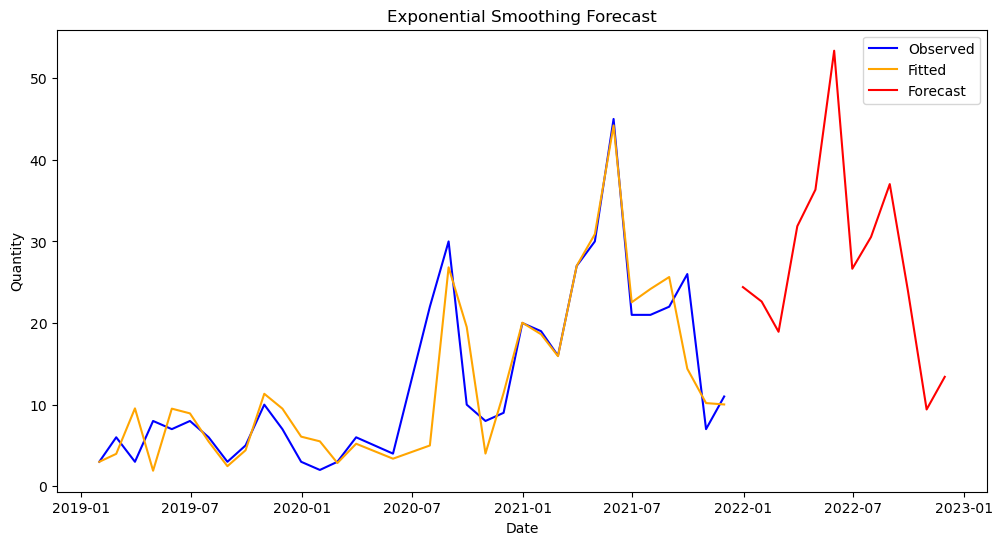

In [222]:
# Plotting
plt.figure(figsize = (12, 6))

plt.plot(product_sales.index, product_sales['qty'], label='Observed', color='blue')
plt.plot(product_sales.index, fit.fittedvalues, label='Fitted', color='orange')
plt.plot(future_dates, forecast, label='Forecast', color='red')

# Title and axis labes
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')

# Add legend and show plot
plt.legend()
plt.show()

In [223]:
# Use the fitted model to make in-sample predictions
in_sample_predictions = fit.fittedvalues

# Calculate MAE and MSE
mae = mean_absolute_error(product_sales['qty'], in_sample_predictions)
mse = mean_squared_error(product_sales['qty'], in_sample_predictions)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

Mean Absolute Error: 2.85
Mean Squared Error: 21.43


On average, each forecast deviates by 2.85 units. Given the size of the dataset (78,391 records), this level of error is very reasonable. This an improvement from the previous value of 5.13. 

**Resources**

Kechinov, M. (2021, December 1). ECommerce purchase history from Jewelry Store. Kaggle. https://www.kaggle.com/datasets/mkechinov/ecommerce-purchase-history-from-jewelry-store

Drive more revenue with niche-specific personalization engine. REES46. (n.d.). https://rees46.com/

GeeksforGeeks. (2024b, May 23). Movie Recommender based on plot summary using TF-IDF vectorization and cosine similarity. https://www.geeksforgeeks.org/movie-recommender-based-on-plot-summary-using-tf-idf-vectorization-and-cosine-similarity/ 
